In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5','4222175.0']
morph_familiar = ['4222153.2','4222154.1','4222153.1','4222174.1','4222157.3']

In [4]:
mouse = '4222174.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1992,4222174.1,04_06_2019,1,TwoTower_foraging,80,1,CA1,2019-06-04,G:\My Drive\VR_Data\TwoTower\4222174.1\04_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\04_06_2...
2024,4222174.1,06_06_2019,2,TwoTower_foraging,91,1,CA1,2019-06-06,G:\My Drive\VR_Data\TwoTower\4222174.1\06_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\06_06_2...
2046,4222174.1,08_06_2019,2,TwoTower_foraging,67,1,CA1,2019-06-08,G:\My Drive\VR_Data\TwoTower\4222174.1\08_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\08_06_2...
2073,4222174.1,11_06_2019,2,TwoTower_foraging,64,1,CA1,2019-06-11,G:\My Drive\VR_Data\TwoTower\4222174.1\11_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\11_06_2...
2095,4222174.1,13_06_2019,2,TwoTower_foraging,66,1,CA1,2019-06-13,G:\My Drive\VR_Data\TwoTower\4222174.1\13_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\13_06_2...
2108,4222174.1,14_06_2019,2,TwoTower_foraging,70,1,CA1,2019-06-14,G:\My Drive\VR_Data\TwoTower\4222174.1\14_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\14_06_2...
2122,4222174.1,15_06_2019,3,TwoTower_foraging,71,1,CA1,2019-06-15,G:\My Drive\VR_Data\TwoTower\4222174.1\15_06_2...,None,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...,G:\My Drive\2P_Data\TwoTower\4222174.1\15_06_2...


In [10]:
sess = df_mouse.iloc[-2]

In [11]:
def sess_lar(sess,max_pos=450,cellmask = None):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
    effMorph = (effMorph+.25)/1.5

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10)
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]


    lar = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        centroid0/np.linalg.norm(centroid0,ord=2)
        centroid1/np.linalg.norm(centroid1,ord=2)
        
        lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
    return lar, effMorph
        

    

In [12]:
lar,em = sess_lar(sess,max_pos=450)

num aberrant ttls 0.0
34560 (34560,) (34560, 21) 97310
frame diff 0


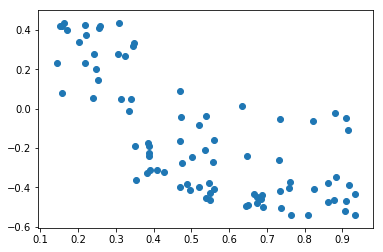

In [13]:
f,ax = plt.subplots()
ax.scatter(em,lar)

In [14]:
def LAR_list_maker(mlist,firstSess = None):
    LAR, EM = {},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse] = [],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0])):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em = sess_lar(sess)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
    return LAR, EM

In [15]:
LAR_rare,EM_rare = LAR_list_maker(morph_rare)

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
frame diff 0
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
frame diff 0
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
frame diff 0
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
frame diff 0
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
frame diff 0
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
frame diff 0
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
frame diff 0
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
frame diff 0
session ind 8
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
frame diff 0
session ind 9
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
frame diff 0
session ind 10
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
frame diff 0
session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
frame diff 0
sess

In [16]:
LAR_fam,EM_fam = LAR_list_maker(morph_familiar)

session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
frame diff 0
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
frame diff 0
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
frame diff 0
session ind 5
num aberrant ttls 0.0
28890 (28890,) (28890, 21) 94524
frame diff 0
session ind 6
num aberrant ttls 0.0
31805 (31805,) (31805, 21) 105737
frame diff 0
session ind 7
num aberrant ttls 0.0
33473 (33473,) (33473, 21) 110483
frame diff 0
session ind 8
num aberrant ttls 0.0
34639 (34639,) (34639, 21) 115107
frame diff 0
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
frame diff 0
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
frame diff 0
session ind 5
num aberrant ttls 0.0
34560 (34560,) (34560, 21) 97310
frame diff 0
session ind 6
num aberrant ttls 0.0
30879 (30879,) (30879, 21) 86531
frame diff 0
session ind 5
num aberrant ttls 0.0
25336 (25336,) (25336, 21) 71554
frame diff 0
session 

In [17]:

def plot_LAR(LAR,EM,cmap='copper'):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
            print(lar.shape)
            ax_scat.scatter(em,lar,color=cmap(np.float(i/N)),alpha=.4,s=8)
            ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4)
    ax_hist.set_ylim([-1.2,1.2])
    ax_scat.set_ylim([-1.2,1.2])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)


(<Figure size 432x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1ed826ca2e8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1ed826e5f98>))

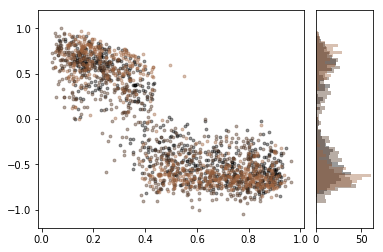

In [47]:
plot_LAR(LAR_rare,EM_rare,cmap='copper')

5
4222153.2
(305,)
4222154.1
(390,)
4222153.1
(186,)
4222174.1
(175,)
4222157.3
(131,)


C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(<Figure size 432x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1ed8276e780>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1ed828b4ef0>))

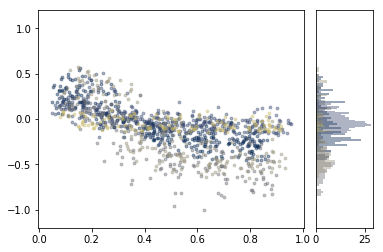

In [48]:


plot_LAR(LAR_fam,EM_fam,cmap='cividis')

In [49]:

def mega_lar(LAR):
    mega_lar =  []
    for k,v in LAR.items():
        mega_lar.extend(v)
    return np.concatenate(mega_lar)
        
mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)
  

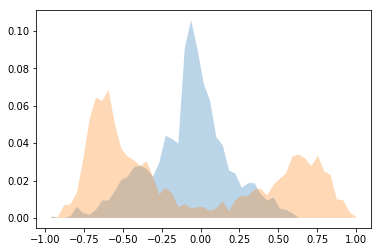

In [50]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3)
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3)

In [52]:
D,p = sp.stats.ks_2samp(mega_lar_rare,mega_lar_fam)
print(D,p)

0.346964950154451 7.881163365277429e-78
